In [ ]:
import sys
import os
sys.path.append(os.path.abspath("DatasetGeneration/DataGenerator"))

from DatasetGeneration.DataGenerator.utils2 import save_kde, load_kde, TruncatedKDE
from DatasetGeneration.DataGenerator.utils import read_dataset
from DatasetGeneration.DataGenerator.scgen import SCGen
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import shutil
from scipy.ndimage import gaussian_filter


def event_image(array_from_h5, img_size: tuple[int, int], normalize: bool = False) -> np.ndarray:
        """
        Rasterise the selected event to a 2-D hit-count map.

        Parameters
        img_size   : (H, W) in pixels
        normalize  : if True, scale to [0,1]

        Returns
        np.ndarray[H,W]   float32 image
        """

        h, w = img_size
        (x_min, x_max), (y_min, y_max) = (-600, 600), (-600, 600)
        sx = (w - 1) / (x_max - x_min)
        sy = (h - 1) / (y_max - y_min)

        img = np.zeros((h, w), dtype=np.float32)
        for ring in array_from_h5['rings']:
            if not len(ring):
                continue
            x_pix = np.rint((ring[:, 0] - x_min) * sx).astype(int)
            y_pix = np.rint((y_max - ring[:, 1]) * sy).astype(int)         # y origin at top
            m = (x_pix >= 0) & (x_pix < w) & (y_pix >= 0) & (y_pix < h)
            img[y_pix[m], x_pix[m]] += 1

        if normalize and img.max() > 0:
            img /= img.max()

        return img



def fromSCgen_to_UNet_format(scgen, output_dir: str, image_size=(256, 256), sigma=2, h5_file=False):
    """
    Organizza i dati generati per UNet: immagini e heatmap gaussiane dei keypoint.

    Parameters
    ----------
    scgen : SCGen
        Generatore dati con eventi simulati.
    output_dir : str
        Cartella di output.
    image_size : tuple[int, int]
        Risoluzione finale (H, W) delle immagini.
    sigma : float
        Deviazione standard della gaussiana per ogni keypoint.
    h5_file : bool
        Se True, i dati provengono da file HDF5.
    """
    img_h, img_w = image_size
    images_dir = os.path.join(output_dir, "images", "train")
    labels_dir = os.path.join(output_dir, "labels", "train")
    centers_dir = os.path.join(output_dir, "centers", "train")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(centers_dir, exist_ok=True)

    # Coordinate del rivelatore
    if not h5_file:
        x_min, x_max = scgen.detector_size[0]
        y_min, y_max = scgen.detector_size[1]
    else:
        x_min, x_max = (-600, 600)
        y_min, y_max = (-600, 600)

    for idx in range(len(scgen)):
        # 1. Carica immagine
        if not h5_file:
            img = scgen.event_image(idx, (img_h, img_w), normalize=False)
        else:
            img = event_image(scgen[idx], (img_h, img_w), normalize=False)
        
        img_uint8 = (255 * img / img.max()).astype(np.uint8) if img.max() > 0 else img.astype(np.uint8)
        img_name = f"event_{idx}.png"
        cv2.imwrite(os.path.join(images_dir, img_name), img_uint8)

        # 2. Estrai centri
        event = scgen[idx]
        centers = event['centers']

        if len(centers) == 0:
            print(f"[WARNING] Nessun keypoint nell'evento {idx}.")
            continue  # Skippa eventi vuoti

        def to_img_coords(x, y):
            x_img = (x - x_min) / (x_max - x_min)
            y_img = (y_max - y) / (y_max - y_min)  # Flip y
            return x_img, y_img

        centers_img = np.array([to_img_coords(x, y) for x, y in centers])
        centers_img[:, 0] *= img_w
        centers_img[:, 1] *= img_h

        # 3. Crea heatmap
        heatmap = np.zeros((img_h, img_w), dtype=np.float32)
        for x, y in centers_img:
            x, y = int(x), int(y)
            if 0 <= x < img_w and 0 <= y < img_h:
                heatmap[y, x] = 1.0

        heatmap = gaussian_filter(heatmap, sigma=sigma)

        # 4. Salva heatmap come PNG
        heatmap_uint8 = (255 * heatmap / heatmap.max()).astype(np.uint8) if heatmap.max() > 0 else heatmap.astype(np.uint8)
        label_name = os.path.splitext(img_name)[0] + ".png"
        cv2.imwrite(os.path.join(labels_dir, label_name), heatmap_uint8)
        
        # 5. Salva i centri in CSV
        centers_df = pd.DataFrame(centers_img, columns=['x', 'y'])
        centers_csv_path = os.path.join(centers_dir, os.path.splitext(img_name)[0] + "_centers.csv")
        centers_df.to_csv(centers_csv_path, index=False)
        
        




def visualize_heatmap_unet(image_path: str, heatmap_path: str, alpha: float = 0.5, cmap='jet', show_side_by_side=False):
    """
    Visualizza un'immagine e la sua heatmap associata (come in UNet).

    Parameters
    ----------
    image_path : str
        Percorso dell'immagine originale (JPG).
    heatmap_path : str
        Percorso della heatmap (PNG, grayscale).
    alpha : float
        Fattore di fusione per sovrapporre la heatmap (0=solo immagine, 1=solo heatmap).
    cmap : str
        Colormap matplotlib per la heatmap (es: 'jet', 'hot', 'viridis').
    show_side_by_side : bool
        Se True, mostra immagine e heatmap affiancate. Se False, sovrapposte.
    """
    # 1. Carica immagine
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Immagine non trovata: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # 2. Carica heatmap
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    if heatmap is None:
        raise FileNotFoundError(f"Heatmap non trovata: {heatmap_path}")
    heatmap = cv2.resize(heatmap, (w, h))  # match dimensions

    # 3. Applica colormap
    heatmap_color = cv2.applyColorMap(heatmap, getattr(cv2, f'COLORMAP_{cmap.upper()}'))

    # 4. Visualizzazione
    if show_side_by_side:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Immagine originale")
        axs[1].imshow(heatmap, cmap=cmap)
        axs[1].set_title("Heatmap")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        overlay = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f"Overlay heatmap\n{os.path.basename(image_path)}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()





def split_train_val(dataset_dir, split_ratio=0.8):
    """
    Divide immagini e label in train e val in base a split_ratio.
    Assume che tutte le immagini e le etichette siano in formato .png.

    Parameters
    ----------
    dataset_dir : str
        Cartella base del dataset (che contiene 'images/train' e 'labels/train').
    split_ratio : float
        Percentuale di dati da tenere per il train (default 0.8).
    """

    # Percorsi
    images_train_dir = os.path.join(dataset_dir, "images", "train")
    labels_train_dir = os.path.join(dataset_dir, "labels", "train")
    centers_train_dir = os.path.join(dataset_dir, "centers", "train")
    images_val_dir   = os.path.join(dataset_dir, "images", "val")
    labels_val_dir   = os.path.join(dataset_dir, "labels", "val")
    centers_val_dir  = os.path.join(dataset_dir, "centers", "val")

    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)
    os.makedirs(centers_val_dir, exist_ok=True)

    # Lista immagini PNG ordinate
    all_images = sorted([f for f in os.listdir(images_train_dir) if f.endswith(".png")])
    split_index = int(len(all_images) * split_ratio)
    val_images = all_images[split_index:]

    # Spostamento diretto
    for img_name in val_images:
        base = os.path.splitext(img_name)[0] + ".png"

        shutil.move(os.path.join(images_train_dir, base), os.path.join(images_val_dir, base))
        shutil.move(os.path.join(labels_train_dir, base), os.path.join(labels_val_dir, base))
        shutil.move(os.path.join(centers_train_dir, base.replace(".png", "_centers.csv")), os.path.join(centers_val_dir, base.replace(".png", "_centers.csv")))

    print(f"Spostate {len(val_images)} immagini (e relative label) nella validation set.")

/user/gr1/delphi/dghezzi/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import of momentum and centers distributions
ptypes = [211, 321, 2212, 11, 13]
log_momenta_dist = {}
for ptype in ptypes:
    log_momenta_dist[ptype] = load_kde(f'DatasetGeneration/distributions/log_momenta_kdes/{ptype}-kde.npz')
centers_dist = load_kde('DatasetGeneration/distributions/centers_R1-kde.npz')
radial_noise = (0, 1.5)  # Mean and standard deviation for radial noise

In [ ]:
# Create the SCGen instance
scgen = SCGen(
    particle_types=ptypes,
    refractive_index=1.0014,
    detector_size=((-600, 600), (-600, 600)),
    momenta_log_distributions=log_momenta_dist,
    centers_distribution=centers_dist,
    radial_noise=radial_noise,
    N_init=20,
    max_radius=100.0
)


# Generate the data
N = 100000
N_rings = (160, 180)
dataset = scgen.generate_dataset(
    num_events=N, # Giovanni ha messo 200 eventi
    num_particles_per_event=N_rings, # Giovanni ha messo (160,180) tuple 
    parallel=True, # NOTA: lasciare TRUE per generare gli eventi in parallelo, altrimenti NON FUNZIONA!
    batch_size=128,
    progress_bar=True
)

print(f"Generated {len(dataset)} events with {sum(len(event['rings']) for event in dataset)} total rings.")


directory = r'/user/gr1/delphi/dghezzi/UNet/UNet_dataset/92000_8000_160_180'

if os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)
    
scgen.save_dataset(f'{directory}.h5')

  0%|          | 0/5000 [00:00<?, ?it/s]/user/gr1/delphi/dghezzi/UNet/DatasetGeneration/DataGenerator/scgen.py:188: RuntimeWarning: invalid value encountered in arccos
  cherenkov_angles = np.where(arccos_arg <= 1, np.arccos(arccos_arg), 0)
100%|██████████| 5000/5000 [08:30<00:00,  9.79it/s]


Generated 5000 events with 850010 total rings.


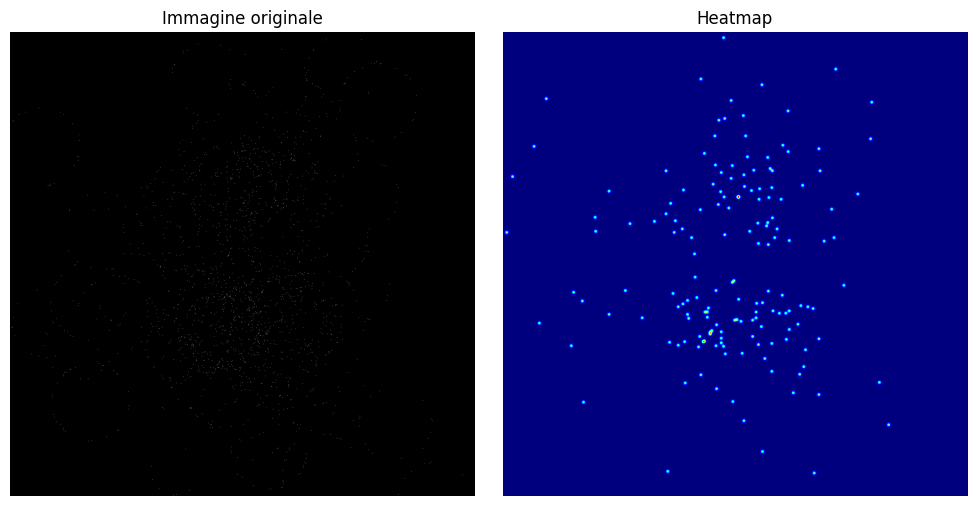

In [ ]:
fromSCgen_to_UNet_format(scgen, directory, image_size=(800, 800), sigma=2, h5_file=False)

visualize_heatmap_unet(
    image_path=os.path.join(directory, "images", "train", "event_1.png"),
    heatmap_path=os.path.join(directory, "labels", "train", "event_1.png"),
    alpha=0.5,
    cmap='jet',
    show_side_by_side=True
)

split_train_val(directory, split_ratio=0.92)

In [5]:
import torch.cuda
torch.cuda.empty_cache()